In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.2 MB/s 


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add,AveragePooling2D,Lambda,
                                     UpSampling2D, Conv2D, MaxPool2D, Dense,Activation,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

# Data

## Data Download

In [ ]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d badasstechie/celebahq-resized-256x256
!unzip "/content/celebahq-resized-256x256.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/celeba_hq_256/25000.jpg  
  inflating: /content/dataset/celeba_hq_256/25001.jpg  
  inflating: /content/dataset/celeba_hq_256/25002.jpg  
  inflating: /content/dataset/celeba_hq_256/25003.jpg  
  inflating: /content/dataset/celeba_hq_256/25004.jpg  
  inflating: /content/dataset/celeba_hq_256/25005.jpg  
  inflating: /content/dataset/celeba_hq_256/25006.jpg  
  inflating: /content/dataset/celeba_hq_256/25007.jpg  
  inflating: /content/dataset/celeba_hq_256/25008.jpg  
  inflating: /content/dataset/celeba_hq_256/25009.jpg  
  inflating: /content/dataset/celeba_hq_256/25010.jpg  
  inflating: /content/dataset/celeba_hq_256/25011.jpg  
  inflating: /content/dataset/celeba_hq_256/25012.jpg  
  inflating: /content/dataset/celeba_hq_256/25013.jpg  
  inflating: /content/dataset/celeba_hq_256/25014.jpg  
  inflating: /content/dataset/celeba_hq_256/25015.jpg  
  inflating: /content/dataset/celeba_hq_256/25016.jpg

## Data Preparation

In [ ]:
NOISE_DIM = 512
BATCH_SIZE = [16, 16, 16, 16, 16, 16,]
EPOCHS = 50

In [ ]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [ ]:
def create_dataset(res,BATCH_SIZE):
  ds_train = tf.keras.preprocessing.image_dataset_from_directory(
      "/content/dataset/celeba_hq_256", label_mode=None, image_size=(res,res), batch_size=BATCH_SIZE
  )
  
  train_dataset = (
      ds_train
      .map(preprocess)
      .unbatch()
      .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
      .batch(BATCH_SIZE,drop_remainder=True)
      .prefetch(tf.data.AUTOTUNE)
  )
  return train_dataset
train_dataset = create_dataset(4,BATCH_SIZE[0])

Found 30000 files belonging to 1 classes.


In [ ]:
train_dataset

<PrefetchDataset element_spec=TensorSpec(shape=(16, 4, 4, 3), dtype=tf.float32, name=None)>

In [ ]:
for d in create_dataset(256,32).take(1):
  print(d.shape)

Found 30000 files belonging to 1 classes.
(32, 256, 256, 3)


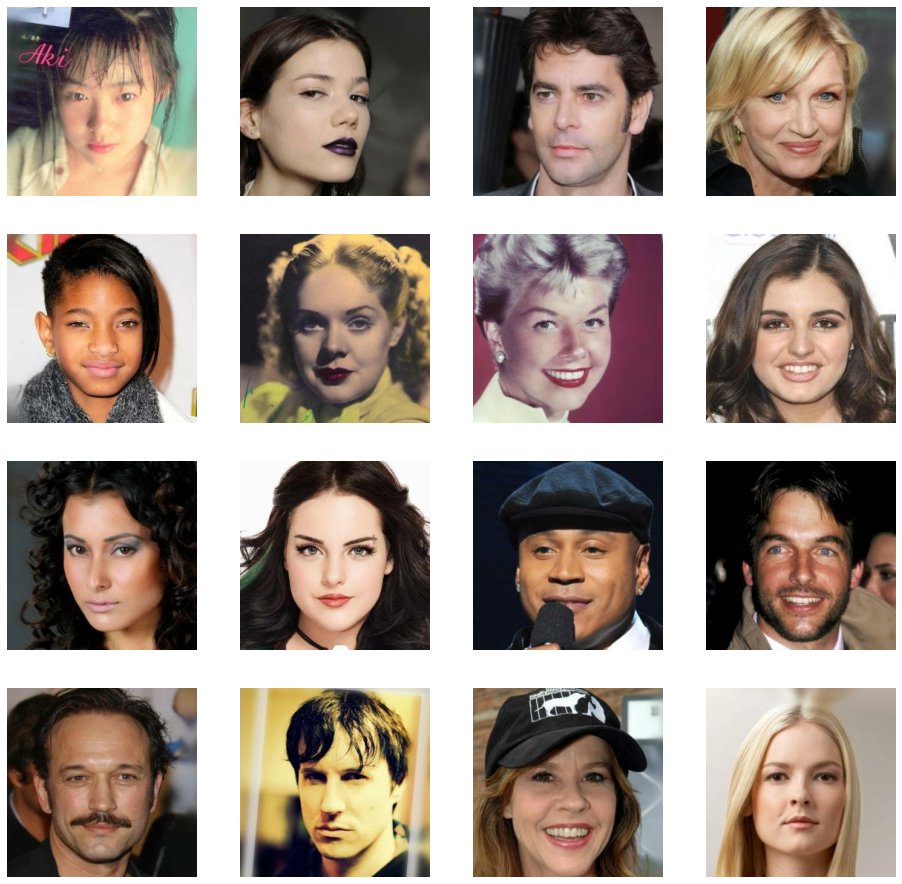

In [ ]:
plt.figure(figsize = (16,16))
k=0
n = 16
for i in range(n):
    ax = plt.subplot(4,4, k+1)
    plt.imshow((d[i]+1)/2)
    plt.axis("off")
    k+=1

# Modeling

In [ ]:
class PixelNormalization(Layer):
  def __init__(self,):
    super(PixelNormalization, self).__init__()
  def call(self, inputs):
    mean_square = tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True)
    l2 = tf.math.rsqrt(mean_square + 1.0e-8)
    normalized = inputs * l2
    return normalized

In [ ]:
class WeightScaling(Layer):
    def __init__(self, shape, gain = np.sqrt(2),):
      super(WeightScaling, self).__init__()
      #shape = tf.constant(shape, dtype=tf.float32)
      fan_in = tf.math.reduce_prod(shape)
      self.wscale = gain*tf.math.rsqrt(fan_in)
      
    def call(self, inputs):
      inputs = tf.cast(inputs, tf.float32)
      return inputs * self.wscale

In [ ]:
class Bias(Layer):
    def __init__(self, ):
        super(Bias, self).__init__()

    def build(self, input_shape):
        b_init = tf.zeros_initializer()
        self.bias = tf.Variable(
            initial_value = b_init(shape=(input_shape[-1],), dtype='float32'),
            trainable=True)  

    def call(self, inputs,):
        return inputs + self.bias

In [ ]:
class WeightScalingDense(Layer):
    def __init__(self, n_units,gain,use_pixelnorm=False,activate=None):
      super(WeightScalingDense, self).__init__()
      self.n_units=n_units
      self.gain=gain
      self.use_pixelnorm=use_pixelnorm
      self.activate=activate
    def build(self,input_shape):

      self.dense=Dense(
          self.n_units,
          use_bias=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),
          dtype='float32')
      self.bias=Bias()


    def call(self,inputs):
      in_filters = tf.shape(inputs)[-1]

      x=self.dense(inputs)

      x=WeightScaling(shape=(tf.cast(in_filters,dtype=tf.float32)), gain=self.gain)(x)
      x=self.bias(x)

      if self.activate=='LeakyReLU':
          x=LeakyReLU(0.2)(x)
      elif self.activate=='tanh':
          x=Activation('tanh')(x)
      
      if self.use_pixelnorm:
          x=PixelNormalization()(x)
      return x

In [ ]:
class WeightScalingConv(Layer):
    def __init__(self, n_filters,kernel_size,gain,use_pixelnorm=False,activate=None, strides=(1,1)):
      super(WeightScalingConv, self).__init__()
      self.n_filters=n_filters
      self.gain=gain
      self.kernel_size=kernel_size
      self.use_pixelnorm=use_pixelnorm
      self.activate=activate
      self.strides=strides
    def build(self,input_shape):
      self.conv=Conv2D(
          self.n_filters,
          self.kernel_size,
          strides=self.strides,
          use_bias=False,
          padding="same",
          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),
          dtype='float32')
      self.bias=Bias()
      
    def call(self,inputs):
      in_filters = tf.shape(inputs)[-1]

      x=self.conv(inputs)
      x=WeightScaling(shape=(tf.cast(self.kernel_size[0],dtype=tf.float32),tf.cast(self.kernel_size[1],dtype=tf.float32),tf.cast(in_filters,dtype=tf.float32)), gain=self.gain)(x)
      x=self.bias(x)
      
      if self.activate=='LeakyReLU':
          x=LeakyReLU(0.2)(x)
      elif self.activate=='tanh':
          x=Activation('tanh')(x)
      
      if self.use_pixelnorm:
          x = PixelNormalization()(x)
      return x 

In [ ]:
class MinibatchStdev(Layer):
    def __init__(self, **kwargs):
      super(MinibatchStdev, self).__init__(**kwargs)
    
    def call(self, inputs):
      mean = tf.reduce_mean(inputs, axis=0, keepdims=True)
      stddev = tf.sqrt(tf.reduce_mean(tf.square(inputs - mean), axis=0, keepdims=True) + 1e-8)
      average_stddev = tf.reduce_mean(stddev, keepdims=True)
      shape = tf.shape(inputs)
      minibatch_stddev = tf.tile(average_stddev, (shape[0], shape[1], shape[2], 1))
      combined = tf.concat([inputs, minibatch_stddev], axis=-1)
      
      return combined

In [ ]:
FILTERS = [512, 512, 512, 512, 256, 128, 64]

In [ ]:
class WeightedSum(Layer):
    def __init__(self,):
      super(WeightedSum, self).__init__()
    def build(self,input_shape):
      self.alpha = tf.Variable(0., dtype=tf.float32, trainable=False)
    def call(self,inputs):
      return ((1.0 - self.alpha) * inputs[0] + (self.alpha * inputs[1]))

In [ ]:
class ProGAN(Model):
    def __init__(self,latent_dim,d_steps=1,gp_weight=10.0,drift_weight=0.001,):
      super(ProGAN, self).__init__()
      self.latent_dim = latent_dim
      self.d_steps = d_steps
      self.gp_weight = gp_weight
      self.drift_weight = drift_weight
      self.n_depth = 0
      self.discriminator = self.init_discriminator()
      self.discriminator_wt_fade = None
      self.generator = self.init_generator()
      self.generator_wt_fade = None

    def init_discriminator(self):
      img_input = Input(shape = (4,4,3))
      img_input = tf.cast(img_input, tf.float32)
      
      # fromRGB
      x=WeightScalingConv(n_filters=FILTERS[0],kernel_size=(1,1),gain=np.sqrt(2),activate='LeakyReLU')(img_input)
      
      x = MinibatchStdev()(x)

      x=WeightScalingConv(n_filters=FILTERS[0],kernel_size=(3,3),gain=np.sqrt(2),activate='LeakyReLU')(x)
      x=WeightScalingConv(n_filters=FILTERS[0],kernel_size=(4,4),gain=np.sqrt(2),activate='LeakyReLU', strides=(4,4))(x)
      
      x = Flatten()(x)
      
      x= WeightScalingDense(n_units=1,gain=1.)(x)

      d_model = Model(img_input, x, name='discriminator')

      return d_model

    def fade_in_discriminator(self):
      input_shape = list(self.discriminator.input.shape)
      
      input_shape = (input_shape[1]*2, input_shape[2]*2, input_shape[3])
      img_input = Input(shape = input_shape)
      img_input = tf.cast(img_input, tf.float32)
      ################## Left
      x1 = AveragePooling2D()(img_input)
      x1 = self.discriminator.layers[1](x1)

      x2=WeightScalingConv(FILTERS[self.n_depth],(1,1),np.sqrt(2),activate='LeakyReLU')(img_input)      
      x2=WeightScalingConv(FILTERS[self.n_depth],(3,3),np.sqrt(2), activate='LeakyReLU')(x2)
      x2=WeightScalingConv(FILTERS[self.n_depth-1],(3,3),np.sqrt(2), activate='LeakyReLU')(x2)

      x2 = AveragePooling2D()(x2)
 
      x = WeightedSum()([x1, x2])

      for i in range(2, len(self.discriminator.layers)):
          x2 = self.discriminator.layers[i](x2)
      self.discriminator_stabilize = Model(img_input, x2, name='discriminator')

      for i in range(2, len(self.discriminator.layers)):
          x = self.discriminator.layers[i](x)
      self.discriminator = Model(img_input, x, name='discriminator')
      self.discriminator.summary()

    def stabilize_discriminator(self):
      self.discriminator = self.discriminator_stabilize
      self.discriminator.summary()

    def init_generator(self):
      noise = Input(shape=(self.latent_dim,))
      x = PixelNormalization()(noise)      
      x=WeightScalingDense(n_units=4*4*FILTERS[0], gain=np.sqrt(2)/4, activate='LeakyReLU', use_pixelnorm=True)(x)

      x = Reshape((4, 4, FILTERS[0]))(x)

      x=WeightScalingConv(FILTERS[0], kernel_size=(4,4), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)(x)
      x=WeightScalingConv(FILTERS[0], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)(x)
      x=WeightScalingConv(3, kernel_size=(1,1), gain=1., activate='tanh', use_pixelnorm=False)(x)
      
      g_model = Model(noise, x, name='generator')
      g_model.summary()
      return g_model

    def fade_in_generator(self):
      block_end = self.generator.layers[-2].output
      block_end = UpSampling2D((2,2))(block_end)
 
      x1 = self.generator.layers[-1](block_end)

      x2=WeightScalingConv(FILTERS[self.n_depth],(3,3),np.sqrt(2),
                           activate='LeakyReLU',use_pixelnorm=True)(block_end)
      x2=WeightScalingConv(FILTERS[self.n_depth],(3,3),np.sqrt(2),
                           activate='LeakyReLU',use_pixelnorm=True)(x2)      
      x2=WeightScalingConv(3,(1,1),1.,activate='tanh',use_pixelnorm=False)(x2)

      self.generator_stabilize = Model(self.generator.input, x2, name='generator')

      x = WeightedSum()([x1, x2])
      self.generator = Model(self.generator.input, x, name='generator')

      self.generator.summary()

    def stabilize_generator(self):
        self.generator = self.generator_stabilize
        self.generator.summary()

    def compile(self, d_optimizer, g_optimizer):
        super(ProGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def gradient_penalty(self,batch_size,real_images,fake_images):
      epsilon=tf.random.normal([batch_size,1,1,1],0.0,1.0)
      interpolation=epsilon*real_images+(1-epsilon)*fake_images

      with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolation)
        prediction=self.discriminator(interpolation,training=True)
      grads=gp_tape.gradient(prediction,interpolation)
      l2_norm=tf.sqrt(tf.reduce_sum(tf.square(grads),axis=[1,2,3]))
      return tf.reduce_mean((l2_norm-1)**2)
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_logits = self.discriminator(fake_images, training=True)
            real_logits = self.discriminator(real_images, training=True)

            d_cost = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

            gp = self.gradient_penalty(batch_size, real_images, fake_images)

            drift = tf.reduce_mean(tf.square(real_logits))
            d_loss = d_cost + self.gp_weight * gp + self.drift_weight * drift

        d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = -tf.reduce_mean(gen_img_logits)
        g_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))
        return {'d_loss': d_loss, 'g_loss': g_loss}

In [ ]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self,prefix,res,latent_dim=512,steps_per_epoch=1000,epochs=50,):
        self.latent_dim = latent_dim
        self.prefix=prefix
        self.steps_per_epoch=steps_per_epoch
        self.epochs=epochs
        self.res=res

    def on_epoch_begin(self, epoch, logs=None):
        self.n_epoch = epoch

    def on_epoch_end(self, epoch, logs=None):
        n=6
        k=0
        out=self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        plt.figure(figsize=(16,16))
        for i in range(n):
          for j in range(n):
            ax=plt.subplot(n,n,k+1)
            plt.imshow((out[k]+1)/2,)
            plt.axis('off')
            k+=1
        plt.savefig("generated/gen_images_{}x{}_{}_epoch_{}.png".format(self.res,self.res,self.prefix,epoch+1))

    def on_batch_begin(self, batch, logs=None):
      alpha = ((self.n_epoch * self.steps_per_epoch) + batch)
                 / float(self.steps_per_epoch * self.epochs - 1)
      for layer in self.model.generator.layers:
        if isinstance(layer, WeightedSum):
          layer.alpha.assign(alpha)
      for layer in self.model.discriminator.layers:
        if isinstance(layer, WeightedSum):
          layer.alpha.assign(alpha)

In [ ]:
1/4999

0.00020004000800160032

In [ ]:
!mkdir generated

In [ ]:
STEPS_PER_EPOCH=1000
EPOCHS=50
NOISE_DIM=512

In [ ]:
50*16*1000

800000

In [ ]:
train_dataset = create_dataset(4,BATCH_SIZE[0])
generator_optimizer = Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)
discriminator_optimizer = Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)

pgan = ProGAN(
    latent_dim = NOISE_DIM, 
    d_steps = 1,
)

pgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
)

cbk=ShowImage('initial',4,latent_dim=512,steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS)
pgan.fit(train_dataset.take(STEPS_PER_EPOCH),epochs = EPOCHS, callbacks=[cbk])

In [ ]:
for n_depth in range(1, 6):

  ################ Faded
  pgan.n_depth = n_depth
  train_dataset=create_dataset(4*(2**n_depth),BATCH_SIZE[n_depth])

  cbk=ShowImage('fading',4*(2**n_depth),latent_dim=512,steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS)
  pgan.fade_in_generator()
  pgan.fade_in_discriminator()

  pgan.compile(
      d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
  )
  
  pgan.fit(train_dataset.take(STEPS_PER_EPOCH),epochs = EPOCHS, callbacks=[cbk])
  
  ################# Stabilized

  cbk=ShowImage('stabilize',4*(2**n_depth),latent_dim=512,steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS)
  pgan.stabilize_generator()
  pgan.stabilize_discriminator()

  pgan.compile(
      d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
  )
  pgan.fit(train_dataset.take(STEPS_PER_EPOCH),epochs=EPOCHS, callbacks=[cbk])

In [ ]:
pgan.generator.save_weights('pggan_generator_128.h5')
pgan.discriminator.save_weights('pggan_discriminator_128.h5')

In [ ]:
def init_discriminator():
  img_input = Input(shape = (4,4,3))
  img_input = tf.cast(img_input, tf.float32)
  
  # fromRGB
  x=WeightScalingConv(FILTERS[0],(1,1),np.sqrt(2),activate='LeakyReLU')(img_input)
  
  x = MinibatchStdev()(x)

  x=WeightScalingConv(FILTERS[0],(3,3),np.sqrt(2),activate='LeakyReLU')(x)
  x=WeightScalingConv(FILTERS[0],(4,4),np.sqrt(2),activate='LeakyReLU', strides=(4,4))(x)
  
  x = Flatten()(x)
  
  x= WeightScalingDense(n_units=1,gain=1.)(x)

  d_model = Model(img_input, x, name='discriminator')

  return d_model

In [ ]:
init_discriminator().summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 4, 4, 3)]         0         
                                                                 
 weight_scaling_conv_49 (Wei  (None, 4, 4, 512)        2048      
 ghtScalingConv)                                                 
                                                                 
 minibatch_stdev_4 (Minibatc  (None, 4, 4, 513)        0         
 hStdev)                                                         
                                                                 
 weight_scaling_conv_50 (Wei  (None, 4, 4, 512)        2364416   
 ghtScalingConv)                                                 
                                                                 
 weight_scaling_conv_51 (Wei  (None, 1, 1, 512)        4194816   
 ghtScalingConv)                                     

In [ ]:
def init_generator():
  noise = Input(shape=(512))
  x = PixelNormalization()(noise)
  
  x=WeightScalingDense(n_units=4*4*FILTERS[0], gain=np.sqrt(2)/4, activate='LeakyReLU', use_pixelnorm=True)(x)

  x = Reshape((4, 4, FILTERS[0]))(x)

  x=WeightScalingConv(FILTERS[0], kernel_size=(4,4), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)(x)
  x=WeightScalingConv(FILTERS[0], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)(x)
  
  x=WeightScalingConv(3, kernel_size=(1,1), gain=1., activate='tanh', use_pixelnorm=False)(x)
  
  g_model = Model(noise, x, name='generator')
  return g_model

In [ ]:
init_generator().summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 512)]             0         
                                                                 
 pixel_normalization_9 (Pixe  (None, 512)              0         
 lNormalization)                                                 
                                                                 
 weight_scaling_dense_9 (Wei  (None, 8192)             4202496   
 ghtScalingDense)                                                
                                                                 
 reshape_9 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 weight_scaling_conv_52 (Wei  (None, 4, 4, 512)        4194816   
 ghtScalingConv)                                                 
                                                         